In [1]:
from astropy.table import Table
from astroquery.vizier import Vizier

from matplotlib import pyplot
import numpy
import pandas
import seaborn

from pathlib import Path

from targets import TARGETS

In [2]:
try:
    catalogue = Table.read('data/usno.ecsv')
except FileNotFoundError:
    Vizier.ROW_LIMIT = 1e6
    catalogue = Vizier.get_catalogs('I/284/out')[0]
    catalogue.write('data/usno.ecsv')

In [3]:
catalogue['R - I'] = catalogue['R1mag'] - catalogue['Imag']
catalogue['B - R'] = catalogue['B1mag'] - catalogue['R1mag']
catalogue['target'] = 'USNO'
catalogue['type'] = 'USNO'

In [4]:
target_means = {
    'type': 'OU',
    'target': [],
    'R - I': [],
    'B - R': [],
}
for table in Path('data').glob('*.ecsv'):
    if table.stem not in TARGETS:
        continue
    photometry = Table.read(table)
    photometry = photometry[photometry['FLAGS'] == 0]
    photometry = photometry.to_pandas()
    
    band_means = photometry.groupby('band').mean()['calibrated_mag']
    if len(band_means) == 0:
        continue
    target_means['target'].append(table.stem)
    target_means['R - I'].append(band_means['R'] - band_means['I'])
    target_means['B - R'].append(band_means['B'] - band_means['R'])

df = pandas.concat([
    catalogue.to_pandas().sample(10000),
    pandas.DataFrame(target_means),
])

(-3.0, 2.9999999999999996)

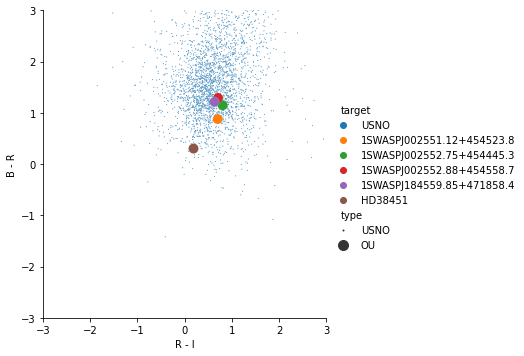

In [5]:
seaborn.relplot(
    data=df,
    x='R - I',
    y='B - R',
    hue='target',
    size='type',
    sizes={'OU': 100, 'USNO': 1},
)
AXIS_LIM = 3
pyplot.xlim([lim if numpy.abs(lim) <= AXIS_LIM else AXIS_LIM * lim/numpy.abs(lim) for lim in pyplot.xlim()])
pyplot.ylim([lim if numpy.abs(lim) <= AXIS_LIM else AXIS_LIM * lim/numpy.abs(lim) for lim in pyplot.ylim()])